In [1]:
import pandas as pd
import numpy as np

<h3> Loading the data </h3>

The task in this dataset is to predict first year GPA of college students based on

1. HSGPA: High school GPA on a 0.0 to 4.0 scale
2. SATV: Verbal/critical reading SAT score
3. SATM: Math SAT score
4. HU: Number of credit hours earned in humanities courses in high school
5. SS: Number of credit hours earned in social science courses in high school
6. CollegeBound: 1=attended a high school where >=50% students intended to go on to college, 0=otherwise

In [2]:
fyGPA = pd.read_csv('firstyearGPA.csv')
fyGPA.head()

,GPA,HSGPA,SATV,SATM,HU,SS,CollegeBound
0,3.06,3.83,680,770,3.0,9.0,1
1,4.15,4.00,740,720,9.0,3.0,1
2,3.41,3.70,640,570,16.0,13.0,1
3,3.21,3.51,740,700,22.0,0.0,1
4,3.48,3.83,610,610,30.5,1.5,1


As usual, we perform train/test split first. We can use random split

In [3]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(fyGPA):
    train_set = fyGPA.loc[train_index]
    test_set = fyGPA.loc[test_index]

And create different variables for input data and target data

In [4]:
trainX = train_set.drop('GPA',axis=1)
trainY = train_set['GPA']
testX = test_set.drop('GPA',axis=1)
testY = test_set['GPA']

trainX.shape, testX.shape, trainY.shape, testY.shape

((164, 6), (55, 6), (164,), (55,))

Some descriptive statistics

In [5]:
trainX.describe()

,HSGPA,SATV,SATM,HU,SS,CollegeBound
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,3.477561,602.378049,632.378049,12.766463,7.466463,0.920732
std,0.359603,87.647249,78.121054,7.438395,5.060411,0.270984
min,2.610000,260.000000,430.000000,0.000000,0.000000,0.000000
25%,3.197500,560.000000,580.000000,7.000000,3.000000,1.000000
50%,3.530000,610.000000,640.000000,12.000000,6.500000,1.000000
75%,3.782500,662.500000,690.000000,17.000000,11.000000,1.000000
max,4.000000,740.000000,800.000000,40.000000,21.000000,1.000000


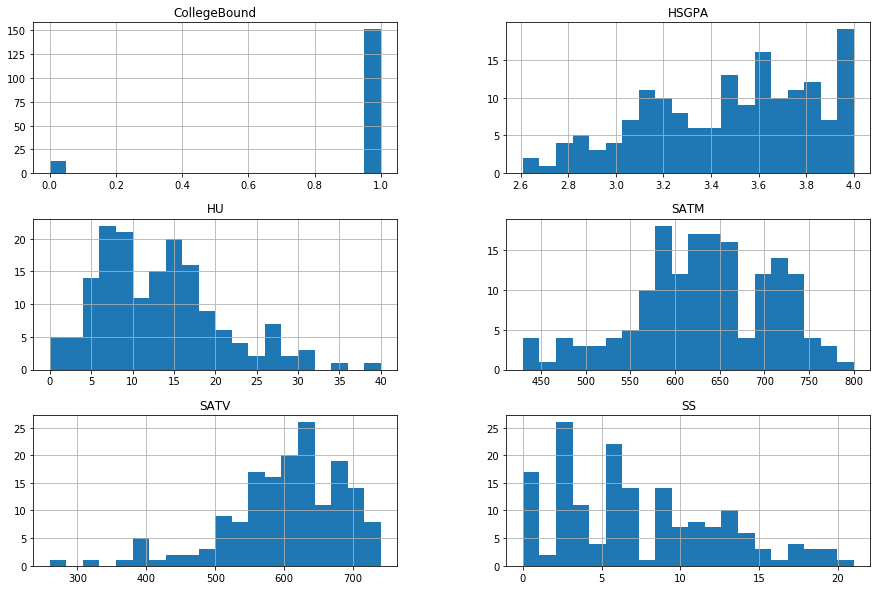

In [6]:
from matplotlib import pyplot as plt

trainX.hist(bins=20, figsize=(15,10))
plt.show()

In [7]:
trainY.describe()

count    164.000000
mean       3.124268
std        0.460804
min        1.930000
25%        2.825000
50%        3.165000
75%        3.492500
max        4.150000
Name: GPA, dtype: float64

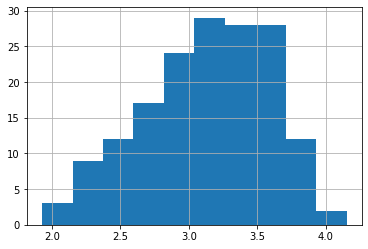

In [8]:
trainY.hist()

There are no missing data or class data, so we can just standardize everything in a single numeric pipeline

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('standardize', StandardScaler())
])

trainX_std = num_pipeline.fit_transform(trainX)

<h3>Modeling</h3>

The simplest model for regression is linear regression

In [31]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()

linear_reg.fit(trainX_std,trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The most common evaluation measurement for regression problem is Mean Squared Error - MSE

In [32]:
from sklearn.metrics import mean_squared_error

#get the prediction
trainY_pred = linear_reg.predict(trainX_std)

#get the MSE
mse_lr = mean_squared_error(trainY, trainY_pred)
print(mse_lr)

0.14552902353784797


And we can obtain the Root Mean Squared Error - RMSE

In [33]:
np.sqrt(mse_lr)

0.3814826647933664

RMSE is intepreted as the average errors between the predicted values and the true values, in this case, the predicted first year GPA and the true first year GPA of the students.

Is this a good model? Recall, the range of GPA is from 0 - 4 (or in this data, 2.0 - 4.15), so is an average error of 0.381 good enough?

Measurements like MSE and RMSE are dependent on the target range, and could be hard to interprete sometimes. We can use a different measurement that is the R-Squared

In [34]:
from sklearn.metrics import r2_score

r2_lr = r2_score(trainY, trainY_pred)
print(r2_lr)

0.31043669279779373


R2 score is always less than 1, and it is interpreted as the percentage of variation in the data that our model can explain. In cases with very bad-fit models, R2 can get to negative values.

In this case, this linear regression model can explain 31% variation in the data, so it is not that good.

<h4>Cross-Validation Measurements</h4>

We've been fitting and testing the linear regression model on the same training data. A better way is to use cross_val_score() as in classification

In [35]:
from sklearn.model_selection import cross_val_score

mse_lr_cv = - cross_val_score(linear_reg, trainX_std, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(linear_reg, trainX_std, trainY, cv=5, scoring='r2')

print('MSE: ', mse_lr_cv.mean())
print('R2: ', r2_lr_cv.mean())

MSE:  0.16180929755761825
R2:  0.20242838730817966


so, this linear regression model is a bit worse when applying on new data.

Let's try a random forest. Note that in this case we need to use RandomForestRegressor instead of RandomForestClassifier as in classification tasks.

In [36]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

mse_rf_cv = - cross_val_score(rf_reg, trainX_std, trainY, cv=5, scoring='neg_mean_squared_error')
r2_rf_cv = cross_val_score(rf_reg, trainX_std, trainY, cv=5, scoring='r2')

print('MSE: ', mse_rf_cv.mean())
print('R2: ', r2_rf_cv.mean())

MSE:  0.174961815939394
R2:  0.14442278205373588


And it is a bit worse than the simple linear regression, possibly due to the small size of this dataset (164 instances in training)

Unlike classification with many measurements to evaluate your models, in regression, most of the times we just use MSE/RMSE and R2. To obtain the predicted value, we can use cross_val_predict()

In [16]:
from sklearn.model_selection import cross_val_predict

trainY_pred_lrcv = cross_val_predict(linear_reg, trainX, trainY, cv=5)

If you want to see the true values and the predicted values

In [17]:
list(zip(trainY, trainY_pred_lrcv))

[(2.58, 2.8938510663738333),
 (3.16, 3.216037052226341),
 (2.51, 3.0278287763695686),
 (2.1, 2.904162729525621),
 (3.41, 3.177196688607547),
 (2.84, 3.405919368087465),
 (2.95, 3.041827942709774),
 (2.4, 2.4283914000233984),
 (2.24, 3.0979242475482147),
 (3.31, 3.0325037509784476),
 (3.68, 2.90908448642938),
 (2.74, 2.9184722570084567),
 (3.11, 3.0987471558495723),
 (3.38, 3.220818162422134),
 (2.91, 3.255707840028155),
 (3.51, 3.3122279929396368),
 (3.0, 2.601933775072194),
 (3.85, 3.5628315724954835),
 (2.59, 3.1130518177905517),
 (3.2, 2.8718116907248934),
 (3.41, 3.5261981555573114),
 (3.34, 2.9539095132493665),
 (3.23, 3.31738935963192),
 (3.37, 3.4087254901484103),
 (2.9, 3.0495638478230886),
 (3.21, 2.765332158894224),
 (3.66, 3.0859815686475627),
 (2.27, 2.7385195580187225),
 (3.13, 2.976713070392505),
 (1.97, 2.439013409048107),
 (3.75, 2.8513503401851814),
 (3.14, 2.68237679385775),
 (3.4, 2.910792534061536),
 (3.33, 3.2154537156720786),
 (2.93, 3.0997248228041774),
 (3.67, 2

<h3> More on Linear Regression Models </h3>

Linear regression is among the simplest models for regression tasks. For a given dataset that have features $x_1, x_2, ... x_k$ and target $y$, linear regression train a model in the form

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_k x_k$

$\beta_0$ is call the intercept, and all other $\beta$ are called coefficients. 

You can see, this model estimates the target $y$ using a <b>linear</b> function of all inputs, hence the name linear regression

In sklearn, we can obtain the coefficients of a trained linear regression model with <b>coef_</b>. The coefficients are in the same order as the input features in the data (in this case, trainX)

In [19]:
linear_reg.coef_

array([ 4.47023943e-01,  1.19798491e-03,  3.04604962e-04,  1.46718021e-02,
        5.63376169e-03, -8.28456914e-03])

In [21]:
trainX.columns

Index(['HSGPA', 'SATV', 'SATM', 'HU', 'SS', 'CollegeBound'], dtype='object')

And the intercept

In [20]:
linear_reg.intercept_

0.433706538432455

So, we can write the equation to predict a student's GPA as

$GPA = 0.4337 + 0.447\times HSGPA + 0.0012\times SATV + 0.0003\times SATM + 0.0147\times HU + 0.0056 \times SS - 0.0083 \times CollegeBound$

And we can use that equation to predict new students' first year GPA (or we can use the predict function of the model)

You can see, this linear regression model previously achieved an R2 of 0.2 - not particularly good for prediction. We can investigate more on this by using scatter plots of the target vs. each feature

HSGPA


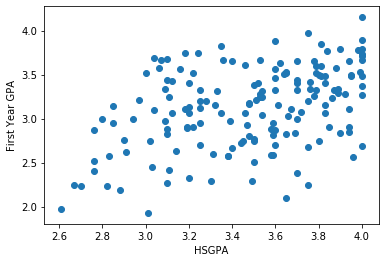

SATV


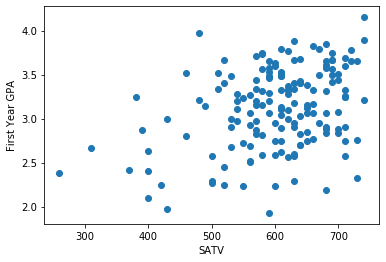

SATM


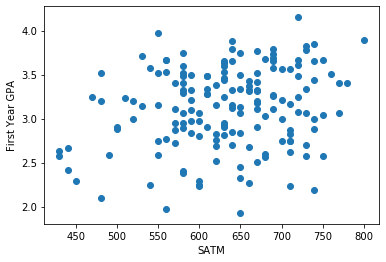

HU


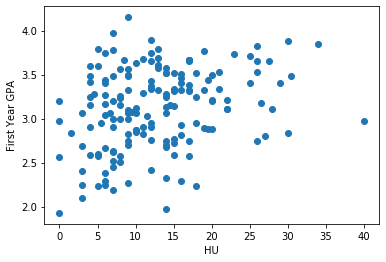

SS


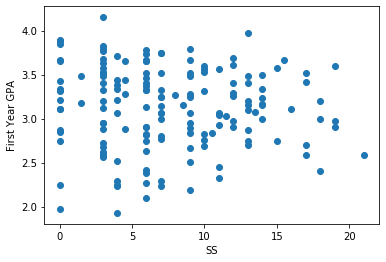

CollegeBound


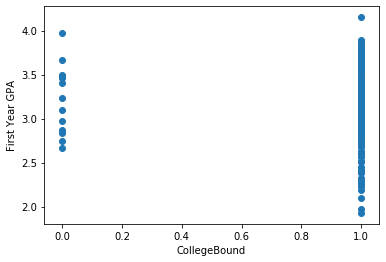

In [24]:
for col in trainX.columns:
    print(col)
    plt.scatter(trainX[col], trainY)
    plt.xlabel(col)
    plt.ylabel('First Year GPA')
    plt.show()

As you can see, none of the features show any strong patterns with the target (first year GPA) - indicated by the spread-out and almost random patterns in all scatter plots. 

There is not much we can do in this kind of data - we don't have enough information to create a good model. 

If you really want to try to improve, however, there could be some curve patterns in the features vs. target. So, we may create log version, and squared version of the features. We will do that with FunctionTransformer and ColumnTransformer as usual

In [26]:
def log_and_sqr_transform(X):                               #input of the function is any dataset X
    log_X = np.log(X + 0.001)                               #log of all columns of X, we add 0.001 to avoid log(0)
    sqr_X = X**2
    return np.c_[X,log_X,sqr_X]    

We will also standardize all columns. So, the complete transformation pipeline is as

In [27]:
from sklearn.preprocessing import FunctionTransformer

num_pipeline_2 = Pipeline([
    ('log and sqr transform', FunctionTransformer(log_and_sqr_transform, validate=False)),
    ('standardize', StandardScaler())
])

Now we transform the data

In [29]:
trainX_prc = num_pipeline_2.fit_transform(trainX)

trainX_prc.shape

(164, 18)

and test another linear regression model

In [30]:
mse_lr2_cv = - cross_val_score(linear_reg, trainX_prc, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr2_cv = cross_val_score(linear_reg, trainX_prc, trainY, cv=5, scoring='r2')

print('MSE: ', mse_lr2_cv.mean())
print('R2: ', r2_lr2_cv.mean())

MSE:  0.17070243102419344
R2:  0.15828810524287534


So... both MSE and R2 become worse, which suggests we probably should just go with the first model. This is not that odd in data analytics, when you try to include more versions of the same features, you may introduce more noises to the input data and ultimately make all models worse.